In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sl
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
from sklearn.neural_network import MLPClassifier

%matplotlib inline
mpl.style.use('ggplot')

In [2]:
#Load the training data to perform EDA
train_df = pd.read_csv("train.csv", index_col=0)

#Load also the validation set to get info about it
test_df = pd.read_csv("test.csv",index_col=0)

#Let's explore it
print("Test set shape:",test_df.shape)
print("\nTrain set info: ")
train_df.info()
train_df.head(5)

Test set shape: (418, 10)

Train set info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Let's drop useless columns since they don't hold any info
#We will drop cabin colum due to high number of missing entries
useless_columns = ['Name','Ticket','Cabin']
train_df = train_df.drop(useless_columns,axis=1)
test_df = test_df.drop(useless_columns,axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [4]:
#Let's get more info about our data
train_df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [5]:
train_df.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


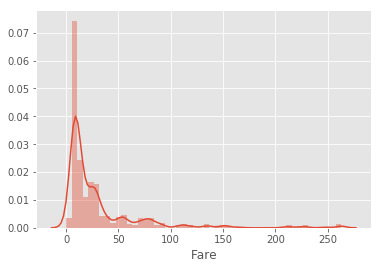

In [6]:
#Let's look at the fare first
#Let's detect any skewness
#Only 1 person @ 500 so we well neglect him
sns.distplot(train_df['Fare'][train_df['Fare'] < 300])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


0    280
1    275
Name: Survived, dtype: int64

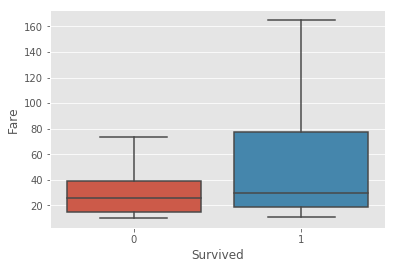

In [7]:
#Too much data points at 10, so let's see if that matters
#Notice I am not showing outliers not to distort the plot
sns.boxplot(x='Survived',y='Fare',data=train_df[['Survived','Fare']][train_df['Fare'] > 10],showfliers=False)
train_df['Survived'][train_df['Fare'] > 10].value_counts()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


0    549
1    342
Name: Survived, dtype: int64

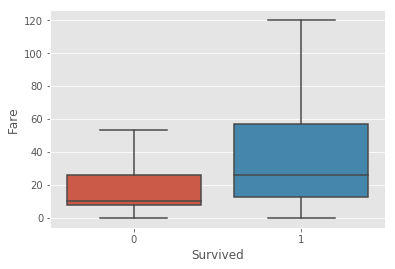

In [8]:
#without the condition
sns.boxplot(x='Survived',y='Fare',data=train_df[['Survived','Fare']],showfliers=False)
train_df['Survived'].value_counts()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


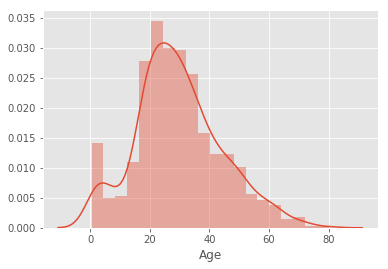

In [9]:
#So, looks like fare actually is a strong indicator of survival

#Let's look at age
#We'll remove NaN in our age analysis only for now
age_df = train_df[["Survived","Age"]].copy()
age_df.dropna(inplace=True)

sns.distplot(age_df['Age'])

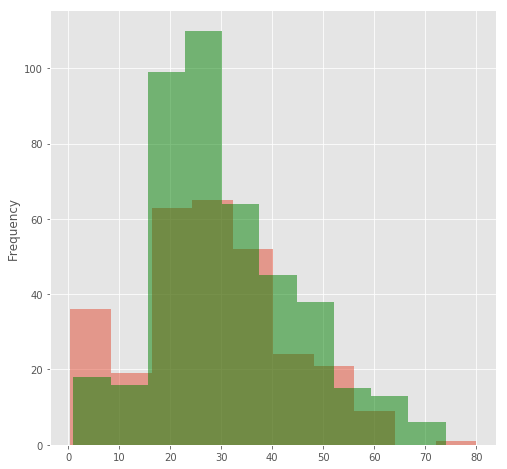

In [10]:
ax = age_df['Age'][age_df['Survived']==1].plot(kind='hist',alpha=0.5,figsize=(8,8))
age_df['Age'][age_df['Survived']==0].plot(kind='hist',alpha=0.5,figsize=(8,8),ax=ax,color='green')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


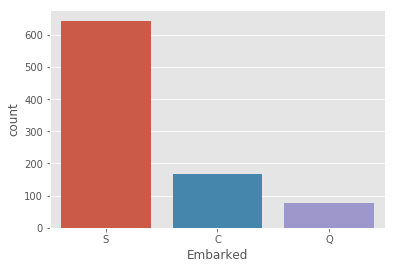

In [11]:
#More likely to survive if greater than 18, but not that of a strong indicator

#Now, the Embarked feature
embr_df = train_df[["Survived","Embarked"]].copy()
embr_df.dropna(inplace=True)

sns.countplot(x="Embarked",data=embr_df)

In [12]:
embr_df = embr_df.groupby("Embarked",as_index=False).mean()
embr_df

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


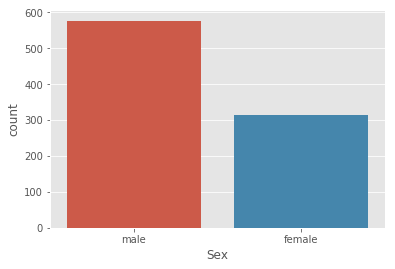

In [13]:
#Looks like S wasn't for survival hehehe

#For sex
sex_df = train_df[["Survived","Sex"]].copy()

sns.countplot(x="Sex",data=sex_df)

In [14]:
sex_df = sex_df.groupby("Sex",as_index=False).mean()
sex_df

,Sex,Survived
0,female,0.742038
1,male,0.188908


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


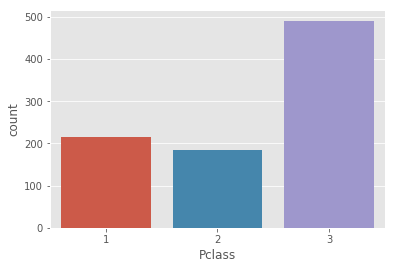

In [15]:
#I hope this makes feminists calm down a little

#For Pclass
pclass_df = train_df[["Survived","Pclass"]].copy()
pclass_df.dropna(inplace=True)

sns.countplot(x="Pclass",data=pclass_df)

In [16]:
pclass_df = pclass_df.groupby("Pclass",as_index=False).mean()
pclass_df

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


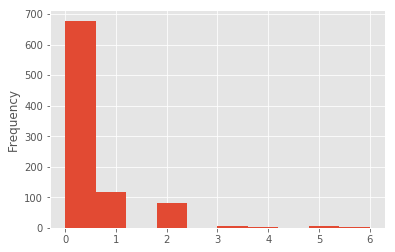

In [17]:
#Pclass is definetly an indicator

arch_df = train_df[["Survived","Parch"]]
arch_df['Parch'].plot(kind="hist")
arch_df.groupby('Parch',as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


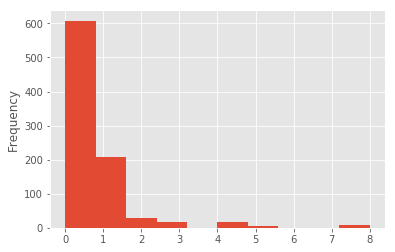

In [18]:
#It's indicative but we probably should just make it a column of whether its 0 or not
#But let's see SibSp first
sib_df = train_df[["Survived","SibSp"]]
sib_df['SibSp'].plot(kind="hist")
sib_df.groupby('SibSp',as_index=False).mean()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Has Family,Survived,Parch,SibSp
0,0,0.303538,0.000000,0.000000
1,1,0.552795,0.236025,0.763975
2,2,0.578431,1.127451,0.872549
3,3,0.724138,1.655172,1.344828
4,4,0.200000,1.866667,2.133333
5,5,0.136364,2.181818,2.818182
6,6,0.333333,2.750000,3.250000
7,7,0.000000,2.666667,4.333333
8,10,0.000000,2.000000,8.000000


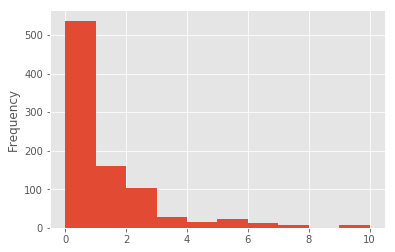

In [19]:
#Let's see if just have family around has use or not
family_df = train_df[["Survived","Parch","SibSp"]]
family_df["Has Family"] = family_df["Parch"] + family_df["SibSp"]
family_df['Has Family'].plot(kind="hist")
family_df.groupby('Has Family',as_index=False).mean()

In [20]:
#Looks like having family is better but just as a binary feature
#So, let's add that as a feature

In [21]:
processed_train = train_df.copy()
average_age = (processed_train['Age']).mean()
processed_train['Age'].replace(np.nan,average_age,inplace=True)
processed_train['Embarked'].replace(np.nan,'S',inplace=True)
processed_train['HasFamily'] = processed_train['Parch'] + processed_train['SibSp']
processed_train['HasFamily'] = processed_train['HasFamily'].astype(bool)
processed_train['HasFamily'] = processed_train['HasFamily'].astype(int)

processed_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasFamily
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1
2,1,1,female,38.0,1,0,71.2833,C,1
3,1,3,female,26.0,0,0,7.9250,S,0
4,1,1,female,35.0,1,0,53.1000,S,1
5,0,3,male,35.0,0,0,8.0500,S,0


In [22]:
processed_train['Pclass'][processed_train['Pclass'] == 1] = 0
processed_train['Pclass'][processed_train['Pclass'] == 3] = 1
processed_train['Pclass'][processed_train['Pclass'] == 0] = 3

processed_train.head()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasFamily
PassengerId,,,,,,,,,
1,0,1,male,22.0,1,0,7.2500,S,1
2,1,3,female,38.0,1,0,71.2833,C,1
3,1,1,female,26.0,0,0,7.9250,S,0
4,1,3,female,35.0,1,0,53.1000,S,1
5,0,1,male,35.0,0,0,8.0500,S,0


In [23]:
processed_test = test_df.copy()
average_age = (processed_test['Age']).mean()
processed_test.replace(np.nan,average_age,inplace=True)

processed_test['HasFamily'] = processed_test['Parch'] + processed_test['SibSp']
#processed_test['HasFamily'] = processed_test['HasFamily'].astype(bool)
processed_test['HasFamily'] = processed_test['HasFamily'].astype(int)

processed_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasFamily
PassengerId,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,0
893,3,female,47.0,1,0,7.0000,S,1
894,2,male,62.0,0,0,9.6875,Q,0
895,3,male,27.0,0,0,8.6625,S,0
896,3,female,22.0,1,1,12.2875,S,2


In [24]:
processed_test['Pclass'][processed_test['Pclass'] == 1] = 0
processed_test['Pclass'][processed_test['Pclass'] == 3] = 1
processed_test['Pclass'][processed_test['Pclass'] == 0] = 3

processed_train.head()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasFamily
PassengerId,,,,,,,,,
1,0,1,male,22.0,1,0,7.2500,S,1
2,1,3,female,38.0,1,0,71.2833,C,1
3,1,1,female,26.0,0,0,7.9250,S,0
4,1,3,female,35.0,1,0,53.1000,S,1
5,0,1,male,35.0,0,0,8.0500,S,0


In [25]:
embarked_one_hot_train = pd.get_dummies(processed_train['Embarked'])
embarked_one_hot_test = pd.get_dummies(processed_test['Embarked'])

In [26]:
gender_one_hot_train = pd.get_dummies(processed_train['Sex'])
gender_one_hot_test = pd.get_dummies(processed_test['Sex'])

In [27]:
processed_train = pd.concat([processed_train, embarked_one_hot_train, gender_one_hot_train],axis=1)
processed_test= pd.concat([processed_test, embarked_one_hot_test, gender_one_hot_test],axis=1)

processed_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasFamily,C,Q,S,female,male
PassengerId,,,,,,,,,,,,,,
1,0,1,male,22.0,1,0,7.2500,S,1,0,0,1,0,1
2,1,3,female,38.0,1,0,71.2833,C,1,1,0,0,1,0
3,1,1,female,26.0,0,0,7.9250,S,0,0,0,1,1,0
4,1,3,female,35.0,1,0,53.1000,S,1,0,0,1,1,0
5,0,1,male,35.0,0,0,8.0500,S,0,0,0,1,0,1


In [28]:
processed_train.drop(columns=["Embarked","Sex"],inplace=True)
processed_test.drop(columns=["Embarked","Sex"],inplace=True)
processed_train.dtypes

Survived       int64
Pclass         int64
Age          float64
SibSp          int64
Parch          int64
Fare         float64
HasFamily      int32
C              uint8
Q              uint8
S              uint8
female         uint8
male           uint8
dtype: object

In [29]:
#Now, the moment of truth
features_list = ["Pclass","Fare","female","Age","male","C","Q","S","HasFamily"]
x_train = processed_train[features_list]
y_train = processed_train[["Survived"]]

In [30]:
x_train.shape

(891, 9)

In [31]:
model = LogisticRegression()
model.fit(x_train,y_train)
model.score(x_train,y_train)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.79012345679012341

In [32]:
model = RandomForestClassifier(n_estimators=1000)

model.fit(x_train, y_train)
model.score(x_train, y_train)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.98204264870931535

In [33]:
model = MLPClassifier(solver='adam',hidden_layer_sizes=(20,3),max_iter=100000,random_state=1,activation='tanh')
model.fit(x_train, y_train)
model.score(x_train, y_train)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.82603815937149272

In [34]:
y_train.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [35]:
yhat = model.predict(x_train).reshape(y_train['Survived'].shape)
train_preds = pd.DataFrame({"Prediction":yhat,"Target":y_train['Survived'],"Age":x_train['Age'],"Pclass":x_train['Pclass'],"Fare":x_train['Fare'],"Female":x_train['female']})

In [36]:
train_preds[train_preds['Prediction'] != train_preds['Target']].sort_values(by=['Prediction'],ascending=True).head(15)

,Prediction,Target,Age,Pclass,Fare,Female
PassengerId,,,,,,
445,0,1,29.699118,1,8.1125,0
448,0,1,34.000000,3,26.5500,0
661,0,1,50.000000,3,133.6500,0
432,0,1,29.699118,1,16.1000,1
431,0,1,28.000000,3,26.5500,0
430,0,1,32.000000,1,8.0500,0
665,0,1,20.000000,1,7.9250,0
415,0,1,44.000000,1,7.9250,0
674,0,1,31.000000,2,13.0000,0


In [37]:
x_test = processed_test[features_list]
model

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [38]:
yhat = model.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": processed_test.index,
        "Survived": yhat
    })
submission.to_csv('titanic.csv', index=False)